# INTRODUÇÃO

House Prices - Advanced Regression Techniques - https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

Este projeto consiste em prever o preço de venda de casas, baseado em uma série de características. O conjunto de dados contém 79 variáveis explicativas, que descrevem (quase) todos os aspectos dos imóveis residenciais em Ames, Iowa. O objetivo é prever o preço final de cada casa.

Neste projeto quis aplicar alguns conhecimentos obtidos em alguns estudos. De forma geral, coloquei em prática alguns conceitos e boas práticas obtidas, como:
* Análise exploratória de dados;
* Tratamento de dados faltantes;
* Otimização de hiperparâmetros usando o **Optuna**;
* Validação cruzada;
* Enconder de variáveis categóricas com **CatBoost Encoonder**;
* Pré-tratamento de dados apenas depois do split, evitando vazamento de dados;
* Utilização de modelos de regressão, como **Gradient Boosting**;
* Análise de métricas de regressão;

![](housesbanner.png)

# Importando as bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score
sns.set_style("whitegrid")

# 1.0 Carregando dataset, separando à variável target e "dropando" variáveis com menos de 60% de dados preenchidos
Pré-análise dos dados

In [2]:
df = pd.read_csv("train.csv")
y = df["SalePrice"]

In [3]:
df = df.drop(["Id", "SalePrice"], axis=1)

In [4]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [6]:
# Quantidade de valores nulos por variável
df.isnull().sum().sort_values(ascending=False).head(25)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageQual        81
GarageCond        81
GarageFinish      81
BsmtFinType2      38
BsmtExposure      38
BsmtCond          37
BsmtFinType1      37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
BedroomAbvGr       0
BsmtHalfBath       0
FullBath           0
KitchenAbvGr       0
HalfBath           0
Functional         0
dtype: int64

## 1.1 Removendo variáveis com menos de 60% de dados preenchidos

A intenção é excluir as variáveis com mais de 40% de dados faltantes, o que daria aproximandamente 1460 * 0.4 = 584 dados faltante.\
Ou seja, se uma variável tem 584 ou mais dados faltantes, ela será excluída.\
Logo, o threshold será em relação à 60% (1460 * 0.6 = 876).

In [7]:
limiar = 0.6 * len(df)
df.dropna(thresh=limiar, axis=1, inplace=True)
print(limiar)

876.0


In [8]:
df.isnull().sum().sort_values(ascending=False).head(14)

LotFrontage     259
GarageType       81
GarageCond       81
GarageYrBlt      81
GarageFinish     81
GarageQual       81
BsmtFinType2     38
BsmtExposure     38
BsmtFinType1     37
BsmtCond         37
BsmtQual         37
MasVnrArea        8
MasVnrType        8
Electrical        1
dtype: int64

# 2.0 Separando as variáveis numéricas e categóricas, levando em conta o dtype delas.

In [9]:
# Variáveis numéricas
var_num = []
for i in df.columns:
    if df[i].dtype == "int64" or df[i].dtype == "float64":
        var_num.append(i)
print(var_num)
print(len(var_num))

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
36


In [10]:
# Variáveis categoricas
var_cat = []
for i in df.columns:
    if df[i].dtype == "object":
        var_cat.append(i)
print(var_cat)
print(len(var_cat))

['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']
38


# 3.0 Analisando as variáveis.

In [11]:
(display(df[var_num].isnull().sum().sort_values(ascending=False).head(4)))

LotFrontage    259
GarageYrBlt     81
MasVnrArea       8
WoodDeckSF       0
dtype: int64

In [12]:
(display(df[var_cat].isnull().sum().sort_values(ascending=False).head(12)))

GarageCond      81
GarageQual      81
GarageFinish    81
GarageType      81
BsmtExposure    38
BsmtFinType2    38
BsmtCond        37
BsmtFinType1    37
BsmtQual        37
MasVnrType       8
Electrical       1
Heating          0
dtype: int64

## 3.1 Analisando às variáveis com sufixo **Garage...**

### GarageCond: Garage condition

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage

### GarageQual: Garage quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage

### GarageFinish: Interior finish of the garage

       Fin	Finished
       RFn	Rough Finished
       Unf	Unfinished
       NA	No Garage

### GarageType: Garage location
		
       2Types	More than one type of garage
       Attchd	Attached to home
       Basment	Basement Garage
       BuiltIn	Built-In (Garage part of house - typically has room above garage)
       CarPort	Car Port
       Detchd	Detached from home
       NA	No Garage

De acordo com a descrição, as variáveis **GarageCond**, **GarageQual**, **GarageFinish** e **GarageType** são relacionadas à variável **GarageYrBlt**. Além de apresentarem dados faltantes, elas apresentam a mesma quantidade de dados faltantes.\
Pesquisando sobre o dataset Kaggle House Prices: Advanced Regression Techniques, encontrei uma informação sobre as garagens. Neste caso os campos "nulos" significam que não há garagem no imovel. Então, vou substituir os valores nulos por 0 na **GarageYrBlt** e NA nas restantes(variáveis categóricas).

Analisando à qualidade das garagens com base nos anos de construção.

<AxesSubplot: xlabel='GarageQual', ylabel='GarageYrBlt'>

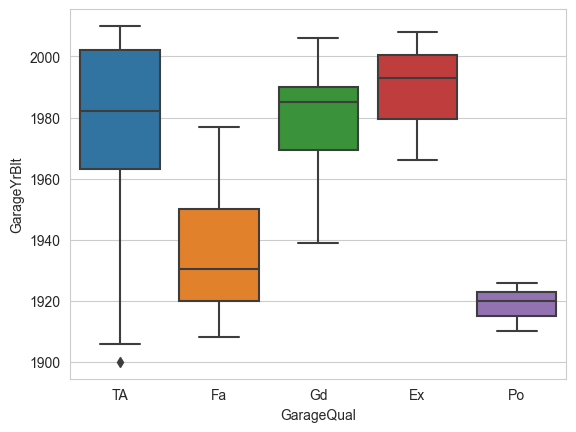

In [13]:
sns.boxplot(y=df["GarageYrBlt"], x=df["GarageQual"])

GarageFinish: Acabamento interior da garagem

        Fin: acabado
        RFn: Bruto Acabado
        Unf: Inacabado
        NA: Sem Garagem

 Podemos notar que à qualidade com maior recorrência é a **TA** (Typical/Average), seguida da **Fa** (Fair) e **Gd** (Good).

<AxesSubplot: xlabel='GarageFinish', ylabel='count'>

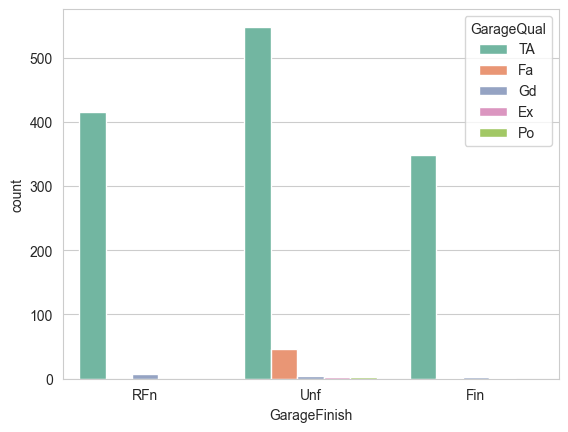

In [14]:
sns.countplot(data=df, x="GarageFinish", hue="GarageQual", palette="Set2")

Logo abaixo podemos notar que as variáveis **GarageCond**, **GarageQual**, **GarageFinish** e **GarageType** apresentam a mesma quantidade de dados faltantes e estes estão nas mesmas linhas.

In [15]:
df[["GarageYrBlt", "GarageCond", "GarageType", "GarageQual", "GarageFinish", "GarageArea", "GarageCars"]].loc[df.GarageYrBlt.isnull()]

,GarageYrBlt,GarageCond,GarageType,GarageQual,GarageFinish,GarageArea,GarageCars
39,NaN,NaN,NaN,NaN,NaN,0,0
48,NaN,NaN,NaN,NaN,NaN,0,0
78,NaN,NaN,NaN,NaN,NaN,0,0
88,NaN,NaN,NaN,NaN,NaN,0,0
89,NaN,NaN,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...
1349,NaN,NaN,NaN,NaN,NaN,0,0
1407,NaN,NaN,NaN,NaN,NaN,0,0
1449,NaN,NaN,NaN,NaN,NaN,0,0
1450,NaN,NaN,NaN,NaN,NaN,0,0


In [16]:
(display(df[var_cat].isnull().sum().sort_values(ascending=False).head(4)))

GarageCond      81
GarageQual      81
GarageFinish    81
GarageType      81
dtype: int64

## 3.2 Analisando à variável **LotFrontage**
LotFrontage: Linear feet of street connected to property

In [17]:
# Quantidade de valores nulos.
df[["LotFrontage"]].isna().sum()

LotFrontage    259
dtype: int64

In [18]:
# Analisando à correlação entre as variáveis.
display(df.corr()["LotFrontage"].sort_values(ascending=False).head(5))
display(df.corr()["LotFrontage"].sort_values(ascending=True).head(5))

C:\Users\Guilherme\AppData\Local\Temp\ipykernel_38708\3886624140.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  display(df.corr()["LotFrontage"].sort_values(ascending=False).head(5))


LotFrontage    1.000000
1stFlrSF       0.457181
LotArea        0.426095
GrLivArea      0.402797
TotalBsmtSF    0.392075
Name: LotFrontage, dtype: float64

C:\Users\Guilherme\AppData\Local\Temp\ipykernel_38708\3886624140.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  display(df.corr()["LotFrontage"].sort_values(ascending=True).head(5))


MSSubClass     -0.386347
OverallCond    -0.059213
BsmtHalfBath   -0.007234
KitchenAbvGr   -0.006069
MiscVal         0.003368
Name: LotFrontage, dtype: float64

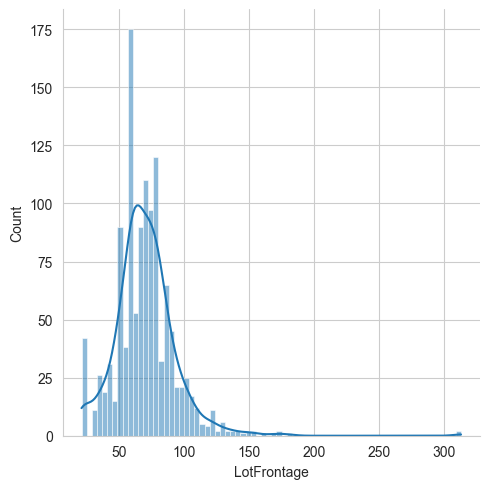

In [19]:
sns.displot(x=df["LotFrontage"], kde=True)

## 3.3 Analisando às variáveis com sufixo **Bsmt**
BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement
		
BsmtCond: Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement
	
BsmtExposure: Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement
	
BsmtFinType1: Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement
		
BsmtFinSF1: Type 1 finished square feet

BsmtFinType2: Rating of basement finished area (if multiple types)

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

BsmtFinSF2: Type 2 finished square feet

BsmtUnfSF: Unfinished square feet of basement area

In [20]:
df[["BsmtExposure","BsmtFinType2"]].loc[df.BsmtExposure.isnull()].shape

(38, 2)

In [21]:
df[["BsmtCond","BsmtFinType1","BsmtQual"]].loc[df.BsmtQual.isnull()].shape

(37, 3)

In [22]:
display(df[["BsmtCond","BsmtFinType1","BsmtQual","BsmtExposure","BsmtFinType2"]].loc[df.BsmtExposure.isnull()])
df[["BsmtCond","BsmtFinType1","BsmtQual","BsmtExposure","BsmtFinType2"]].loc[df.BsmtExposure.isnull()].shape

,BsmtCond,BsmtFinType1,BsmtQual,BsmtExposure,BsmtFinType2
17,NaN,NaN,NaN,NaN,NaN
39,NaN,NaN,NaN,NaN,NaN
90,NaN,NaN,NaN,NaN,NaN
102,NaN,NaN,NaN,NaN,NaN
156,NaN,NaN,NaN,NaN,NaN
182,NaN,NaN,NaN,NaN,NaN
259,NaN,NaN,NaN,NaN,NaN
342,NaN,NaN,NaN,NaN,NaN
362,NaN,NaN,NaN,NaN,NaN
371,NaN,NaN,NaN,NaN,NaN


(38, 5)

In [23]:
display(df[["BsmtCond","BsmtFinType1","BsmtQual","BsmtExposure","BsmtFinType2"]].loc[df.BsmtFinType2.isnull()])

,BsmtCond,BsmtFinType1,BsmtQual,BsmtExposure,BsmtFinType2
17,NaN,NaN,NaN,NaN,NaN
39,NaN,NaN,NaN,NaN,NaN
90,NaN,NaN,NaN,NaN,NaN
102,NaN,NaN,NaN,NaN,NaN
156,NaN,NaN,NaN,NaN,NaN
182,NaN,NaN,NaN,NaN,NaN
259,NaN,NaN,NaN,NaN,NaN
332,TA,GLQ,Gd,No,NaN
342,NaN,NaN,NaN,NaN,NaN
362,NaN,NaN,NaN,NaN,NaN


Ás variáveis **BsmtQual**, **BsmtCond**, **BsmtExposure**, **BsmtFinType1**, **BsmtFinType2** apresentam a mesma quantidade de dados faltantes e estes estão nas mesmas linhas.\
Exceto pelas linhas 332 e 948, que apresentam dados faltantes em **BsmtFinType2** e **BsmtExposure**.

In [24]:
print("Index 948")
display(df[["BsmtCond","BsmtFinType1","BsmtQual","BsmtExposure","BsmtFinType2"]].iloc[948])
print("Index 332")
display(df[["BsmtCond","BsmtFinType1","BsmtQual","BsmtExposure","BsmtFinType2"]].iloc[332])

Index 948


BsmtCond         TA
BsmtFinType1    Unf
BsmtQual         Gd
BsmtExposure    NaN
BsmtFinType2    Unf
Name: 948, dtype: object

Index 332


BsmtCond         TA
BsmtFinType1    GLQ
BsmtQual         Gd
BsmtExposure     No
BsmtFinType2    NaN
Name: 332, dtype: object

## 3.4 Analisando às variáveis com sufixo **Mas**
MasVnrType: tipo de alvenaria.

        BrkCmn: Bloco Comum
        BrkFace: Face de tijolo
        CBlock: Bloco de concreto
        None: Nenhum
        Stone: Pedra
	
MasVnrArea: Área de alvenaria em pés quadrados

In [25]:
df[["MasVnrType", "MasVnrArea"]].isna().sum()

MasVnrType    8
MasVnrArea    8
dtype: int64

In [26]:
display(df[["MasVnrType","MasVnrArea"]].loc[df.MasVnrType.isnull()])
df[["MasVnrType","MasVnrArea"]].loc[df.MasVnrType.isnull()].shape

,MasVnrType,MasVnrArea
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN
977,NaN,NaN
1243,NaN,NaN
1278,NaN,NaN


(8, 2)

In [27]:
display(df[["MasVnrType","MasVnrArea"]].loc[df.MasVnrType == "None"])

,MasVnrType,MasVnrArea
1,None,0.0
3,None,0.0
5,None,0.0
8,None,0.0
9,None,0.0
...,...,...
1454,None,0.0
1455,None,0.0
1457,None,0.0
1458,None,0.0


<AxesSubplot: xlabel='MasVnrType', ylabel='MasVnrArea'>

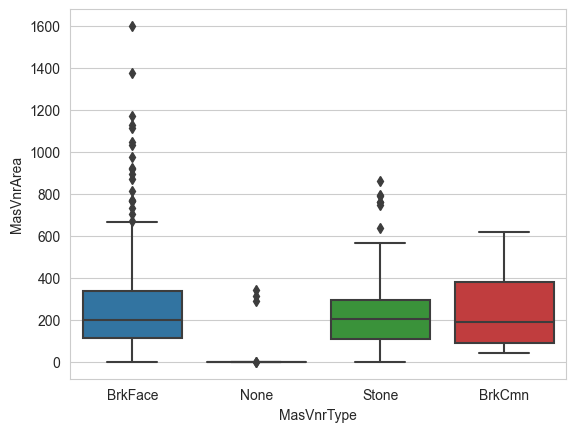

In [28]:
sns.boxplot(y=df["MasVnrArea"], x=df["MasVnrType"])

# 4.0 Dividindo o dataset em treino e teste

In [29]:
x_train, x_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=1)

In [30]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1022, 74), (438, 74), (1022,), (438,))

# 5.0 Tratar os valores faltantes

In [31]:
# Função para visualizar os valores nulos.
def view_null():
    return x_train.isnull().sum().sort_values(ascending=False).head(), x_test.isnull().sum().sort_values(ascending=False).head()

In [32]:
print("Categóricas")
display(df[var_cat].isnull().sum().sort_values(ascending=False).head(12))
print("Numéricas")
display(df[var_num].isnull().sum().sort_values(ascending=False).head(4))

Categóricas


GarageCond      81
GarageQual      81
GarageFinish    81
GarageType      81
BsmtExposure    38
BsmtFinType2    38
BsmtCond        37
BsmtFinType1    37
BsmtQual        37
MasVnrType       8
Electrical       1
Heating          0
dtype: int64

Numéricas


LotFrontage    259
GarageYrBlt     81
MasVnrArea       8
WoodDeckSF       0
dtype: int64

## 5.1 Tratando os valores faltantes das variáveis com sufixo **Garage...**

In [33]:
df_garage = df[["GarageYrBlt", "GarageCond", "GarageType", "GarageQual", "GarageFinish", "GarageArea", "GarageCars"]]
df_garage.isnull().sum()

GarageYrBlt     81
GarageCond      81
GarageType      81
GarageQual      81
GarageFinish    81
GarageArea       0
GarageCars       0
dtype: int64

In [34]:
garage_num = []
garage_cat = []
for i in df_garage.columns:
    if df_garage[i].dtype == "int64" or df_garage[i].dtype == "float64":
        garage_num.append(i)
    elif df_garage[i].dtype == "object":
        garage_cat.append(i)
print(garage_num)
print("Quantidade de variáveis númericas: {}".format(len(garage_num)))
print(garage_cat)
print("Quantidade de variáveis categóricas: {}".format(len(garage_cat)))

['GarageYrBlt', 'GarageArea', 'GarageCars']
Quantidade de variáveis númericas: 3
['GarageCond', 'GarageType', 'GarageQual', 'GarageFinish']
Quantidade de variáveis categóricas: 4


Nas variáveis **GarageCond**, **GarageQual**, **GarageFinish** e **GarageType** substitui os valores faltantes por **None**.\
Nas variávieis **GarageYrBlt**, **GarageArea**, **GarageCars** substitui os valores faltantes por 0.

In [35]:
for i in garage_cat:
    x_train[i].fillna("None", inplace=True)
    x_test[i].fillna("None", inplace=True)

In [36]:
for i in garage_num:
    x_train[i].fillna(0, inplace=True)
    x_test[i].fillna(0, inplace=True)


In [37]:
display(x_train.isnull().sum().sort_values(ascending=False).head(12))
display(x_test.isnull().sum().sort_values(ascending=False).head(12))

LotFrontage     188
BsmtExposure     29
BsmtFinType2     29
BsmtQual         28
BsmtCond         28
BsmtFinType1     28
MasVnrType        6
MasVnrArea        6
Electrical        1
TotRmsAbvGrd      0
KitchenQual       0
KitchenAbvGr      0
dtype: int64

LotFrontage     71
BsmtExposure     9
BsmtQual         9
BsmtFinType2     9
BsmtCond         9
BsmtFinType1     9
MasVnrType       2
MasVnrArea       2
MSSubClass       0
TotRmsAbvGrd     0
KitchenQual      0
KitchenAbvGr     0
dtype: int64

## 5.2 Tratando os valores faltantes da **LotFrontage**

Usando à média da **LotFrontage** da base de treino para substituir na base de teste e treino, evitando assim o vazamento de dados.

In [38]:
x_train["LotFrontage"].fillna(x_train["LotFrontage"].mean(), inplace=True)
x_test["LotFrontage"].fillna(x_train["LotFrontage"].mean(), inplace=True)

In [39]:
display(x_train.isnull().sum().sort_values(ascending=False).head(8))
display(x_test.isnull().sum().sort_values(ascending=False).head(8))

BsmtFinType2    29
BsmtExposure    29
BsmtFinType1    28
BsmtQual        28
BsmtCond        28
MasVnrType       6
MasVnrArea       6
Electrical       1
dtype: int64

BsmtExposure    9
BsmtCond        9
BsmtFinType2    9
BsmtFinType1    9
BsmtQual        9
MasVnrType      2
MasVnrArea      2
TotRmsAbvGrd    0
dtype: int64

In [40]:
view_null()

(BsmtFinType2    29
 BsmtExposure    29
 BsmtFinType1    28
 BsmtQual        28
 BsmtCond        28
 dtype: int64,
 BsmtExposure    9
 BsmtCond        9
 BsmtFinType2    9
 BsmtFinType1    9
 BsmtQual        9
 dtype: int64)

## 5.3 Tratando os valores faltantes das variáveis com sufixo **Bsmt...**

In [41]:
df_bsmt = df[["BsmtExposure","BsmtFinType2","BsmtCond","BsmtFinType1","BsmtQual"]]

bsmt_num = []
bsmt_cat = []

for i in df_bsmt.columns:
    if df_bsmt[i].dtype == "int64" or df_bsmt[i].dtype == "float64":
        bsmt_num.append(i)
    elif df_bsmt[i].dtype == "object":
        bsmt_cat.append(i)
print(bsmt_num)
print("Quantidade de variáveis númericas: {}".format(len(bsmt_num)))
print(bsmt_cat)
print("Quantidade de variáveis categóricas: {}".format(len(bsmt_cat)))

[]
Quantidade de variáveis númericas: 0
['BsmtExposure', 'BsmtFinType2', 'BsmtCond', 'BsmtFinType1', 'BsmtQual']
Quantidade de variáveis categóricas: 5


Os valores nulos foram substituídos por "no_basement" nas variáveis **BsmtQual**, **BsmtCond**, **BsmtExposure**, **BsmtFinType1**, **BsmtFinType2**.

In [42]:
for i in df_bsmt:
    x_train[i].fillna("no_basement", inplace=True)
    x_test[i].fillna("no_basement", inplace=True)

In [43]:
view_null()

(MasVnrType    6
 MasVnrArea    6
 Electrical    1
 MSSubClass    0
 HalfBath      0
 dtype: int64,
 MasVnrType    2
 MasVnrArea    2
 MSSubClass    0
 HalfBath      0
 Functional    0
 dtype: int64)

## 5.4 Tratando os valores faltantes das variáveis com sufixo **Mas...**
Na variável **MasVnrType** substitui os valores faltantes utilizando à estrategia "most_frequent".\
Na variável **MasVnrArea** substitui os valores faltantes utilizando à média da coluna.

In [44]:
imp_constant= SimpleImputer(strategy="most_frequent")
x_train["MasVnrType"] = imp_constant.fit_transform(x_train[["MasVnrType"]])
x_test["MasVnrType"] = imp_constant.transform(x_test[["MasVnrType"]])

In [45]:
x_train["MasVnrArea"].fillna(x_train["MasVnrArea"].mean(), inplace=True)
x_test["MasVnrArea"].fillna(x_train["MasVnrArea"].mean(), inplace=True)

In [46]:
view_null()

(Electrical      1
 MSSubClass      0
 FullBath        0
 Functional      0
 TotRmsAbvGrd    0
 dtype: int64,
 MSSubClass      0
 GarageType      0
 Functional      0
 TotRmsAbvGrd    0
 KitchenQual     0
 dtype: int64)

## 5.4 Tratando o valor falta na variável **Electrical**\
Na variável **Electrical** substitui o valor faltante utilizando à estrategia "most_frequent".

In [47]:
x_train["Electrical"].unique()

array(['SBrkr', 'FuseA', 'FuseF', nan, 'FuseP', 'Mix'], dtype=object)

In [48]:
x_train[["Electrical"]].loc[x_train.Electrical.isnull()]

,Electrical
1379,NaN


In [49]:
imp_constant= SimpleImputer(strategy="most_frequent")
x_train[["Electrical"]] = imp_constant.fit_transform(x_train[["Electrical"]])

In [50]:
x_train[["Electrical"]].loc[1379]

Electrical    SBrkr
Name: 1379, dtype: object

In [51]:
display(x_train)
display(x_test)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
632,20,RL,85.000000,11900,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,0,4,2009,WD,Family
208,60,RL,70.309353,14364,Pave,IR1,Low,AllPub,Inside,Mod,...,55,0,0,154,0,0,4,2007,WD,Normal
83,20,RL,80.000000,8892,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,0,7,2007,COD,Normal
1174,70,RL,80.000000,16560,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,0,7,2006,WD,Normal
250,30,RL,55.000000,5350,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,450,5,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,20,RL,78.000000,10140,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,0,8,2009,WD,Normal
905,20,RL,80.000000,9920,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,164,0,0,0,0,2,2010,WD,Normal
1096,70,RM,60.000000,6882,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,115,0,0,0,0,3,2007,WD,Normal
235,160,RM,21.000000,1680,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,0,8,2008,WD,Normal


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
258,60,RL,80.000000,12435,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,96,0,245,0,0,0,5,2008,WD,Normal
267,75,RL,60.000000,8400,Pave,Reg,Bnk,AllPub,Inside,Mod,...,24,0,0,0,0,0,7,2008,WD,Normal
288,20,RL,70.309353,9819,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,0,2,2010,WD,Normal
649,180,RM,21.000000,1936,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,0,12,2007,WD,Normal
1233,20,RL,70.309353,12160,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,0,5,2010,COD,Abnorml
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793,20,RL,76.000000,9158,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,130,0,0,0,0,0,6,2007,New,Partial
631,120,RL,34.000000,4590,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,73,0,0,0,0,0,8,2007,WD,Normal
1172,160,FV,35.000000,4017,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,54,0,0,0,0,0,3,2008,WD,Normal
1167,60,RL,58.000000,10852,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,38,0,0,0,0,0,2,2006,WD,Normal


# 6.0 Pré-processamento dos dados.
Encode das variáveis categóricas.\
Normalização dos dados.

In [52]:
import category_encoders

In [53]:
# Extraindo tipos das variáveis
# 1.1
var_num = []
var_cat = []
for i in x_train.columns:
    if x_train[i].dtype == "int64" or x_train[i].dtype == "float64":
        var_num.append(i)
    else:
        var_cat.append(i)

print ("Variáveis númericas: {var_num}".format(var_num=var_num))
print ("Variáveis categóricas: {var_cat}".format(var_cat=var_cat))

# 1.2
numerical_ix = x_train.select_dtypes(include=['int64', 'float64']).columns
categorical_ix = x_train.select_dtypes(include=['object', 'bool']).columns

Variáveis númericas: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
Variáveis categóricas: ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'Gar

In [54]:
t = [('num_continuas', StandardScaler(), numerical_ix), 
     ('str_categoricas', category_encoders.CatBoostEncoder(), categorical_ix)]

preprocessor = ColumnTransformer(transformers=t)

### Usando o fit_transform para treino e o transform para teste.

In [55]:
x_train = preprocessor.fit_transform(x_train, y_train)
x_test = preprocessor.transform(x_test)

# 7.0 Prevendo os valores de **SalePrice** com *Gradient Boosting Regressor*

In [56]:
validaca_cruzada = KFold(n_splits=10, shuffle=True, random_state=2)

In [57]:
gbr_v1 = GradientBoostingRegressor(random_state = 1)
score = (cross_val_score(gbr_v1, x_train, y_train, cv=validaca_cruzada, scoring="neg_mean_squared_error"))
np.mean(np.sqrt(score * -1))

30289.41720110724

# 8.0 Prevendo os valores de **SalePrice** com *GradientBoostingRegressor* - Ajustando os hiperparâmetros do modelo utilizando *Optuna*.

In [58]:
import optuna
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

c:\Users\Guilherme\anaconda3\envs\curso_datascience\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 8.1 Criando à funcão objetito para o *Optuna*, está que será utilizada para ajustar os hiperparâmetros do modelo.
### Recomendo à leitura do seguinte artigo para entender melhor à função objetivo: https://towardsdatascience.com/why-is-everyone-at-kaggle-obsessed-with-optuna-for-hyperparameter-tuning-7608fdca337c\
### Temos que ter em mente que o "neg_mean_squared_error" no "cross_val_score" retornará valores de saída negativos, por isso é necessário multiplicar por -1 o score, já que queremos fazer à minimização do erro.


In [59]:
def objective(trial, X, y, cv, scoring):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 5000, step=100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 9),
        "subsample": trial.suggest_float("subsample", 0.5, 0.9, step=0.1),
        "max_features": trial.suggest_categorical("max_features", ["auto", "sqrt", "log2"]),
        "random_state": 1,
        "n_iter_no_change": 50,
        "validation_fraction": 0.05,
    }
    # Perform CV
    gr_reg = GradientBoostingRegressor(**params)
    scores = cross_val_score(gr_reg, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    # Compute RMSLE
    # rmsle = np.sqrt(-scores["test_score"].mean())
    score = np.mean(np.sqrt(scores * -1))
    
    return score

## 8.2 Criando à função study para o *Optuna* e definindo à métrica de avaliação do modelo.

In [60]:
study = optuna.create_study(direction="minimize")
kf = KFold(n_splits=5, shuffle=True, random_state=42)
func = lambda trial: objective(trial, x_train, y_train, kf, "neg_mean_squared_error")

[I 2022-12-15 14:09:12,790] A new study created in memory with name: no-name-941d837e-d67f-49e8-bd67-3ee88cd1dc2c


## 8.3 Defininindo às quantidades de ensaios.
### Resolvi começar com 50 trials, depois 200 trials e por fim 300 trials, totalizando 50 trials.

### 8.3.1
### trials = 50

In [61]:
study.optimize(func, n_trials=50, show_progress_bar=False)
print("Melhores parâmetros: {}".format(study.best_params))
print("Score: {}".format(study.best_value))

[I 2022-12-15 14:09:21,404] Trial 0 finished with value: 29058.33372670305 and parameters: {'n_estimators': 3700, 'learning_rate': 0.003822018158626204, 'max_depth': 6, 'subsample': 0.7, 'max_features': 'sqrt'}. Best is trial 0 with value: 29058.33372670305.
[I 2022-12-15 14:09:22,928] Trial 1 finished with value: 42523.912396842556 and parameters: {'n_estimators': 200, 'learning_rate': 0.005383341300357128, 'max_depth': 9, 'subsample': 0.5, 'max_features': 'log2'}. Best is trial 0 with value: 29058.33372670305.
[I 2022-12-15 14:10:10,913] Trial 2 finished with value: 34228.173550740925 and parameters: {'n_estimators': 3500, 'learning_rate': 0.0005107533413957339, 'max_depth': 9, 'subsample': 0.6, 'max_features': 'auto'}. Best is trial 0 with value: 29058.33372670305.
[I 2022-12-15 14:10:13,307] Trial 3 finished with value: 30355.122210047663 and parameters: {'n_estimators': 800, 'learning_rate': 0.12797404381659097, 'max_depth': 5, 'subsample': 0.6, 'max_features': 'auto'}. Best is tr

Melhores parâmetros: {'n_estimators': 2500, 'learning_rate': 0.0361336160467106, 'max_depth': 3, 'subsample': 0.8, 'max_features': 'log2'}
Score: 28370.84170940436


### 8.3.2
### trials = 200

In [62]:
study.optimize(func, n_trials=200, show_progress_bar=False)
print("Melhores parâmetros: {}".format(study.best_params))
print("Score: {}".format(study.best_value))

[I 2022-12-15 14:12:02,274] Trial 50 finished with value: 28896.497132863627 and parameters: {'n_estimators': 2300, 'learning_rate': 0.027067234735684682, 'max_depth': 5, 'subsample': 0.8, 'max_features': 'log2'}. Best is trial 35 with value: 28370.84170940436.
[I 2022-12-15 14:12:03,401] Trial 51 finished with value: 29617.586661915335 and parameters: {'n_estimators': 2500, 'learning_rate': 0.033217066096152055, 'max_depth': 4, 'subsample': 0.8, 'max_features': 'log2'}. Best is trial 35 with value: 28370.84170940436.
[I 2022-12-15 14:12:03,879] Trial 52 finished with value: 29962.827754133476 and parameters: {'n_estimators': 2300, 'learning_rate': 0.09026028577325215, 'max_depth': 4, 'subsample': 0.8, 'max_features': 'log2'}. Best is trial 35 with value: 28370.84170940436.
[I 2022-12-15 14:12:07,325] Trial 53 finished with value: 30186.174163850934 and parameters: {'n_estimators': 1800, 'learning_rate': 0.052422987335507674, 'max_depth': 3, 'subsample': 0.8, 'max_features': 'auto'}. B

Melhores parâmetros: {'n_estimators': 700, 'learning_rate': 0.041772769805004654, 'max_depth': 4, 'subsample': 0.8, 'max_features': 'sqrt'}
Score: 27963.316819983324


### 8.3.3
### trials = 300

In [63]:
study.optimize(func, n_trials=300, show_progress_bar=False)
print("Melhores parâmetros: {}".format(study.best_params))
print("Score: {}".format(study.best_value))

[I 2022-12-15 14:15:37,999] Trial 250 finished with value: 28558.743927385734 and parameters: {'n_estimators': 500, 'learning_rate': 0.034362359117917386, 'max_depth': 4, 'subsample': 0.8, 'max_features': 'sqrt'}. Best is trial 132 with value: 27963.316819983324.
[I 2022-12-15 14:15:38,457] Trial 251 finished with value: 28555.672945983017 and parameters: {'n_estimators': 300, 'learning_rate': 0.05279801081928574, 'max_depth': 4, 'subsample': 0.8, 'max_features': 'sqrt'}. Best is trial 132 with value: 27963.316819983324.
[I 2022-12-15 14:15:39,317] Trial 252 finished with value: 28532.54031776301 and parameters: {'n_estimators': 600, 'learning_rate': 0.02422955943874197, 'max_depth': 4, 'subsample': 0.8, 'max_features': 'sqrt'}. Best is trial 132 with value: 27963.316819983324.
[I 2022-12-15 14:15:39,913] Trial 253 finished with value: 28050.071493953157 and parameters: {'n_estimators': 400, 'learning_rate': 0.041599627203874, 'max_depth': 4, 'subsample': 0.8, 'max_features': 'sqrt'}. 

Melhores parâmetros: {'n_estimators': 4300, 'learning_rate': 0.07401992421257272, 'max_depth': 4, 'subsample': 0.5, 'max_features': 'auto'}
Score: 27179.17177937267


## 8.4 Visualizando os resultados do *Optuna* com o auxilio da biblioteca *Optuna.visualization*.
### Podemos notar uma diminuição consíderável do erro quadrático médio após os ajustes dos hiperparâmetros, com uma diminuição de aproximadamente 10.20% do erro quadrático médio.

### Valores do score: 

    Sem o ajuste dos hiperparâmetros
    Score: 30289.41720110724

    Com o ajuste dos hiperparâmetros
    Ápos 300 trials, totalizando 550 trials.
    Score: 27179.17177937267

C:\Users\Guilherme\AppData\Local\Temp\ipykernel_38708\2486159970.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study);


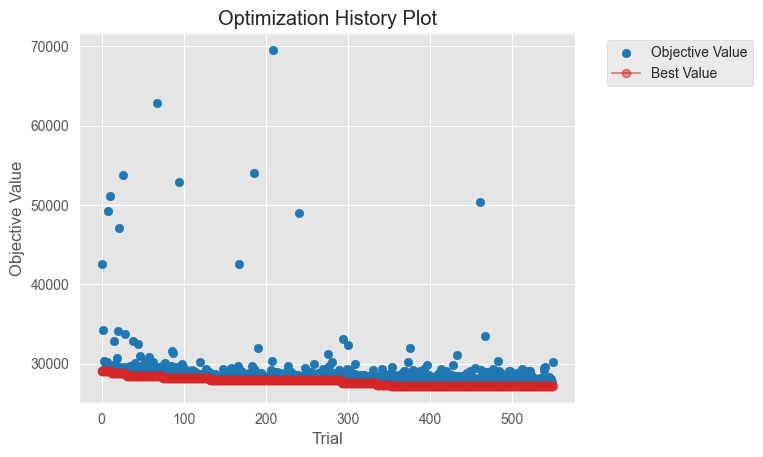

In [64]:

from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study);

## 8.5 Aqui podemos visualizar à importância de cada hiperparâmetro para diminuição da métrica de avaliação.

C:\Users\Guilherme\AppData\Local\Temp\ipykernel_38708\1756647795.py:3: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study);


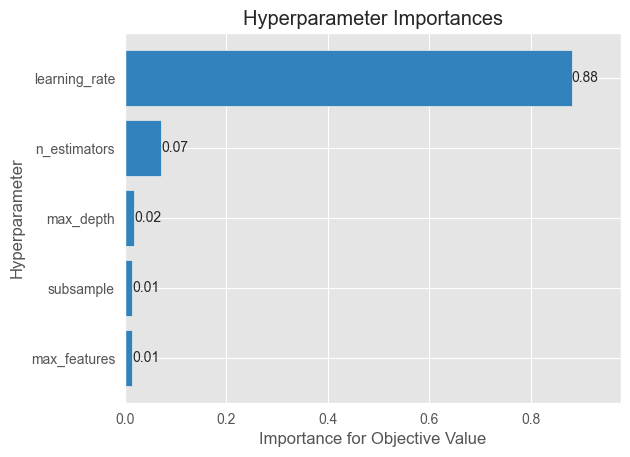

In [65]:
from optuna.visualization.matplotlib import plot_param_importances

plot_param_importances(study);

# 9.0 Predizendo os valores de **SalePrice** dos dados de teste com *GradientBoostingRegressor*, com os hiperparâmetros ajustados pelo *Optuna*.

In [ ]:
model_tuned = GradientBoostingRegressor(**study.best_params)
model_tuned.fit(x_train, y_train)

y_pred= model_tuned.predict(x_test)

In [79]:
from sklearn.metrics import mean_squared_error, r2_score
import math

rmse = math.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE: {rmse}".format(rmse=rmse))
print("R2: {r2}".format(r2=r2))

RMSE: 22658.141997227776
R2: 0.9280994922041413
